# Run a SageMaker Experiment with Pytorch DDP - MNIST Handwritten Digits Classification

This notebook shows how you can use the SageMaker SDK to track a Machine Learning experiment. 

We introduce two concepts in this notebook -

* *Experiment:* An experiment is a collection of runs. When you initialize a run in your training loop, you include the name of the experiment that the run belongs to. Experiment names must be unique within your AWS account. 
* *Run:* A run consists of all the inputs, parameters, configurations, and results for one iteration of model training. Initialize an experiment run for tracking a training job with Run(). 

To execute this notebook in SageMaker Studio, you should select the `PyTorch 1.12 Python 3.8 CPU Optimizer image`.


You can track artifacts for experiments, including datasets, algorithms, hyperparameters and metrics. Experiments executed on SageMaker such as SageMaker training jobs are automatically tracked and any existing SageMaker experiment on your AWS account is automatically migrated to the new UI version.

We demonstrate these capabilities through a PyTorch DDP - MNIST handwritten digits classification example. The experiment is organized as follows:

1. Download and prepare the MNIST dataset.
2. Train a Convolutional Neural Network (CNN) Model. Tune the hyperparameter that configures the number of hidden channels in the model. Track the parameter configurations and resulting model accuracy using the SageMaker Experiments Python SDK.
3. Finally use the search and analytics capabilities of the SDK to search, compare and evaluate the performance of all model versions generated from model tuning in Step 2.
4. We also show an example of tracing the complete lineage of a model version: the collection of all the data pre-processing and training configurations and inputs that went into creating that model version.

Make sure you select the `PyTorch 1.12 Python 3.8 CPU Optimized` kernel in Amazon SageMaker Studio.

## Runtime

This notebook takes approximately 25 minutes to run.

## Contents

1. [Install modules](#Install-modules)
1. [Setup](#Setup)
1. [Download the dataset](#Download-the-dataset)
1. [Step 1: Set up the Experiment](#Step-1:-Set-up-the-Experiment)

## Install modules

In [1]:
import sys

In [4]:
# update boto3 and sagemaker to ensure latest SDK version
!{sys.executable} -m pip uninstall -y sagemaker
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install --upgrade boto3 --no-cache-dir
!{sys.executable} -m pip install --upgrade sagemaker==2.123.0 --no-cache-dir
!{sys.executable} -m pip install --upgrade torch
!{sys.executable} -m pip install --upgrade torchvision

Found existing installation: sagemaker 2.132.0
Uninstalling sagemaker-2.132.0:
  Successfully uninstalled sagemaker-2.132.0
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:0000:01
  Attempting uninstall: pip
    Found existing installation: pip 22.3.1
    Uninstalling pip-22.3.1:
      Successfully uninstalled pip-22.3.1
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 156.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.71
    Uninstalling botocore-1.29.71:
      Successfully uninstalled botocore-1.29.71
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.71
    Uninstalling boto3-1.26.71:
      Successfully uninstalled boto

### Install the SageMaker Experiments Python SDK

## Setup

In [2]:
import time
import os
import importlib
import boto3
import numpy as np
import pandas as pd
from IPython.display import set_matplotlib_formats
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session


s3 = boto3.client("s3")

set_matplotlib_formats("retina")

/tmp/ipykernel_11680/1041990755.py:18: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("retina")


In [3]:
sm_sess = sagemaker.Session()
sess = sm_sess.boto_session
sm = sm_sess.sagemaker_client
role = get_execution_role()
region = sess.region_name

## Download the dataset
We download the MNIST handwritten digits dataset, and then apply a transformation on each image.

In [5]:
bucket = sm_sess.default_bucket()
prefix = "DEMO-mnist"
print("Using S3 location: s3://" + bucket + "/" + prefix + "/")

datasets.MNIST.urls = [
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/train-labels-idx1-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-images-idx3-ubyte.gz",
    "https://sagemaker-sample-files.s3.amazonaws.com/datasets/image/MNIST/t10k-labels-idx1-ubyte.gz",
]

# Download the dataset to the ./mnist folder, and load and transform (normalize) them
train_set = datasets.MNIST(
    "mnist",
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

test_set = datasets.MNIST(
    "mnist",
    train=False,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    ),
    download=False,
)

Using S3 location: s3://sagemaker-us-west-1-030086719966/DEMO-mnist/


View an example image from the dataset.

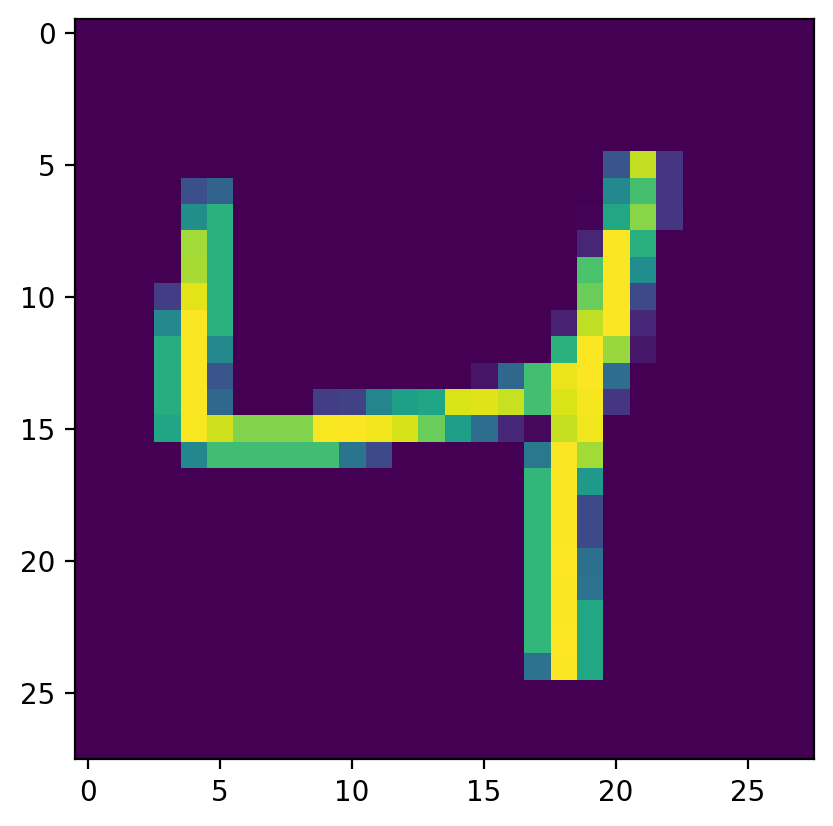

In [6]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to S3.

In [7]:
inputs = sagemaker.Session().upload_data(path="mnist", bucket=bucket, key_prefix=prefix)
print("S3 path for data: ", inputs)

S3 path for data:  s3://sagemaker-us-west-1-030086719966/DEMO-mnist


## Prepare Training Script for Distributed Data Parallel

In [11]:
%%writefile ./mnist_ddp.py


import argparse
import json
import logging
import os
import sys
import time
from os.path import join

os.system("pip install -U sagemaker")

import boto3
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torch.utils.data.distributed
from torchvision import datasets, transforms
from sagemaker.session import Session
from sagemaker.experiments.run import Run, load_run

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler(sys.stdout))

boto_session = boto3.session.Session(region_name=os.environ["AWS_REGION"])
sagemaker_session = Session(boto_session=boto_session)


if "SAGEMAKER_METRICS_DIRECTORY" in os.environ:
    log_file_handler = logging.FileHandler(
        join(os.environ["SAGEMAKER_METRICS_DIRECTORY"], "metrics.json")
    )
    formatter = logging.Formatter(
        "{'time':'%(asctime)s', 'name': '%(name)s', \
    'level': '%(levelname)s', 'message': '%(message)s'}",
        style="%",
    )
    log_file_handler.setFormatter(formatter)
    logger.addHandler(log_file_handler)

# Based on https://github.com/pytorch/examples/blob/master/mnist/main.py
class Net(nn.Module):
    def __init__(self, hidden_channels, kernel_size, drop_out):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_channels, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(hidden_channels, 20, kernel_size=kernel_size)
        self.conv2_drop = nn.Dropout2d(p=drop_out)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


def _get_train_data_loader(batch_size, training_dir, is_distributed, **kwargs):
    logger.info("Get train data loader")
    dataset = datasets.MNIST(
        training_dir,
        train=True,
        transform=transforms.Compose(
            [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
        ),
        download=False,
    )
    train_sampler = (
        torch.utils.data.distributed.DistributedSampler(dataset) if is_distributed else None
    )
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=train_sampler is None,
        sampler=train_sampler,
        **kwargs,
    )


def _get_test_data_loader(test_batch_size, training_dir, **kwargs):
    logger.info("Get test data loader")
    return torch.utils.data.DataLoader(
        datasets.MNIST(
            training_dir,
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
            download=False,
        ),
        batch_size=test_batch_size,
        shuffle=True,
        **kwargs,
    )


def _average_gradients(model):
    # Gradient averaging.
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM)
        param.grad.data /= size


def train(args, tracker=None):
    print("------ number of hosts --------", len(args.hosts))
    is_distributed = len(args.hosts) > 1 and args.backend is not None
    logger.debug("Distributed training - {}".format(is_distributed))
    use_cuda = args.num_gpus > 0
    logger.debug("Number of gpus available - {}".format(args.num_gpus))
    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
    device = torch.device("cuda" if use_cuda else "cpu")
    rank = None

    if is_distributed:
        # Initialize the distributed environment.
        world_size = len(args.hosts)
        os.environ["WORLD_SIZE"] = str(world_size)
        host_rank = args.hosts.index(args.current_host)
        os.environ["RANK"] = str(host_rank)
        dist.init_process_group(backend=args.backend, rank=host_rank, world_size=world_size)
        rank = dist.get_rank()
        print("------- rank --------", rank)
        logger.info(
            "Initialized the distributed environment: '{}' backend on {} nodes. ".format(
                args.backend, dist.get_world_size()
            )
            + "Current host rank is {}. Number of gpus: {}".format(dist.get_rank(), args.num_gpus)
        )

    # set the seed for generating random numbers
    torch.manual_seed(args.seed)
    if use_cuda:
        torch.cuda.manual_seed(args.seed)

    train_loader = _get_train_data_loader(args.batch_size, args.data_dir, is_distributed, **kwargs)
    test_loader = _get_test_data_loader(args.test_batch_size, args.data_dir, **kwargs)

    logger.info(
        "Processes {}/{} ({:.0f}%) of train data".format(
            len(train_loader.sampler),
            len(train_loader.dataset),
            100.0 * len(train_loader.sampler) / len(train_loader.dataset),
        )
    )

    logger.info(
        "Processes {}/{} ({:.0f}%) of test data".format(
            len(test_loader.sampler),
            len(test_loader.dataset),
            100.0 * len(test_loader.sampler) / len(test_loader.dataset),
        )
    )

    model = Net(args.hidden_channels, args.kernel_size, args.dropout).to(device)
    if is_distributed and use_cuda:
        # multi-machine multi-gpu case
        model = torch.nn.parallel.DistributedDataParallel(model)
    else:
        # single-machine multi-gpu case or single-machine or multi-machine cpu case
        model = torch.nn.DataParallel(model)

    if args.optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    else:
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

    with load_run(sagemaker_session=sagemaker_session) as run:
        run.log_parameters(vars(args))
        for epoch in range(1, args.epochs + 1):
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader, 1):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = F.nll_loss(output, target)
                loss.backward()
                if is_distributed and not use_cuda:
                    # average gradients manually for multi-machine cpu case only
                    _average_gradients(model)
                optimizer.step()
                if batch_idx % args.log_interval == 0 and rank == 0:
                    logger.info(
                        "Train Epoch: {} [{}/{} ({:.0f}%)], Train Loss: {:.6f};".format(
                            epoch,
                            batch_idx * len(data),
                            len(train_loader.sampler),
                            100.0 * batch_idx / len(train_loader),
                            loss.item(),
                        )
                    )
            if rank == 0:
                test_loss, correct, target, pred = test(model, test_loader, device, tracker)
                logger.info(
                    "Test Average loss: {:.4f}, Test Accuracy: {:.0f}%;\n".format(
                        test_loss, 100.0 * correct / len(test_loader.dataset)
                    )
                )
                run.log_metric(name="train_loss", value=loss.item(), step=epoch)
                run.log_metric(name="test_loss", value=test_loss, step=epoch)
                run.log_metric(
                    name="test_accuracy",
                    value=100.0 * correct / len(test_loader.dataset),
                    step=epoch,
                )
    save_model(model, args.model_dir)


def test(model, test_loader, device, tracker=None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()  # sum up batch loss
            pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    return test_loss, correct, target, pred


def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    hidden_channels = int(os.environ.get("hidden_channels", "5"))
    kernel_size = int(os.environ.get("kernel_size", "5"))
    dropout = float(os.environ.get("dropout", "0.5"))
    model = torch.nn.DataParallel(Net(hidden_channels, kernel_size, dropout))
    with open(os.path.join(model_dir, "model.pth"), "rb") as f:
        model.load_state_dict(torch.load(f))
        return model.to(device)


def save_model(model, model_dir):
    logger.info("Saving the model.")
    path = os.path.join(model_dir, "model.pth")
    # recommended way from http://pytorch.org/docs/master/notes/serialization.html
    torch.save(model.cpu().state_dict(), path)


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Data and model checkpoints directories
    parser.add_argument(
        "--batch-size",
        type=int,
        default=64,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=1000,
        metavar="N",
        help="input batch size for testing (default: 1000)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=10,
        metavar="N",
        help="number of epochs to train (default: 10)",
    )
    parser.add_argument("--optimizer", type=str, default="sgd", help="optimizer for training.")
    parser.add_argument(
        "--lr",
        type=float,
        default=0.01,
        metavar="LR",
        help="learning rate (default: 0.01)",
    )
    parser.add_argument(
        "--dropout",
        type=float,
        default=0.5,
        metavar="DROP",
        help="dropout rate (default: 0.5)",
    )
    parser.add_argument(
        "--kernel_size",
        type=int,
        default=5,
        metavar="KERNEL",
        help="conv2d filter kernel size (default: 5)",
    )
    parser.add_argument(
        "--momentum",
        type=float,
        default=0.5,
        metavar="M",
        help="SGD momentum (default: 0.5)",
    )
    parser.add_argument(
        "--hidden_channels",
        type=int,
        default=10,
        help="number of channels in hidden conv layer",
    )
    parser.add_argument("--seed", type=int, default=1, metavar="S", help="random seed (default: 1)")
    parser.add_argument(
        "--log-interval",
        type=int,
        default=100,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument(
        "--backend",
        type=str,
        default="nccl",
        help="backend for distributed training (tcp, gloo on cpu and gloo, nccl on gpu)",
    )

    # Container environment
    parser.add_argument("--hosts", type=list, default=json.loads(os.environ["SM_HOSTS"]))
    parser.add_argument("--current-host", type=str, default=os.environ["SM_CURRENT_HOST"])
    parser.add_argument("--model-dir", type=str, default=os.environ["SM_MODEL_DIR"])
    parser.add_argument("--data-dir", type=str, default=os.environ["SM_CHANNEL_TRAINING"])
    parser.add_argument("--num-gpus", type=int, default=os.environ["SM_NUM_GPUS"])

    args = parser.parse_args()

    train(args)

Overwriting ./mnist_ddp.py


## Step 1: Set up the Experiment

### Create an Experiment

In [12]:
from sagemaker.pytorch import PyTorch

If you want to run the following five training jobs in parallel, you may need to increase your resource limit. Here we run them sequentially.

In [14]:
from sagemaker.experiments.run import Run

experiment_name = "distributed-train-job-experiment-final"
run_name = "run-ddp-1"
with Run(
    experiment_name=experiment_name,
    run_name=run_name,
    sagemaker_session=sm_sess,
) as run:
    est = PyTorch(
        entry_point="./mnist_ddp.py",
        role=role,
        model_dir=False,
        framework_version="1.12",
        py_version="py38",
        instance_type="ml.c4.8xlarge",
        instance_count=2,
        hyperparameters={
            "epochs": 10,
            "hidden_channels": 20,
            "backend": "gloo",
            "dropout": 0.2,
            "kernel_size": 5,
            "optimizer": "sgd",
        },
        keep_alive_period_in_seconds=10 * 60,  # keeping the instance warm for 10mins
    )
    est.fit(
        inputs={"training": inputs},
    )

INFO:sagemaker.experiments.run:The run (run-ddp-1) under experiment (distributed-train-job-experiment-final) already exists. Loading it. Note: sagemaker.experiments.load_run is recommended to use when the desired run already exists.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-28-09-01-54-152


2023-02-28 09:01:54 Starting - Starting the training job...
2023-02-28 09:02:20 Starting - Preparing the instances for training......
2023-02-28 09:03:19 Downloading - Downloading input data...
2023-02-28 09:03:39 Training - Downloading the training image...
2023-02-28 09:04:04 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-28 09:04:29,446 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-28 09:04:29,447 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-28 09:04:29,449 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-02-28 09:04:29,460 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-28 09:04:29,462 sagemaker_pytorch_container.training INFO     Invoking user training